In [ ]:
!pip install hstrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
from hstrader import HsTrader
from hstrader.models import Event, Tick, Order, CrtOrder, OrderType, SideType, Status, Position, Resolution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as

In [100]:
CLIENT_ID = "Your HsTrader client id"
SECRET = "Your HsTrader secret"


In [ ]:
# create an instance of HsTrader client
client = HsTrader(CLIENT_ID, SECRET)

In [ ]:
# HsTrader symbol
symbol = client.get_symbol("EURUSD")
# HsTrader market data
data = client.get_market_history(symbol, resolution=Resolution.D1,count_back = 1000)

In [ ]:

df = pd.DataFrame([historytick.dict() for historytick in data])
print(df)


                         time     open     high      low    close  \
0   2024-03-03 23:59:00+00:00  1.08368  1.08413  1.08368  1.08385   
1   2024-03-04 00:00:00+00:00  1.08385  1.08669  1.08385  1.08540   
2   2024-03-05 00:00:00+00:00  1.08540  1.08758  1.08397  1.08548   
3   2024-03-06 00:00:00+00:00  1.08548  1.09153  1.08413  1.08990   
4   2024-03-07 00:00:00+00:00  1.08990  1.09512  1.08673  1.09507   
..                        ...      ...      ...      ...      ...   
111 2024-07-11 00:00:00+00:00  1.08330  1.08996  1.08315  1.08741   
112 2024-07-12 00:00:00+00:00  1.08741  1.09113  1.08614  1.09039   
113 2024-07-13 00:00:00+00:00  1.09039  1.09039  1.08799  1.08855   
114 2024-07-15 00:00:00+00:00  1.08855  1.09223  1.08827  1.08974   
115 2024-07-16 00:00:00+00:00  1.08974  1.08987  1.08828  1.08984   

           volume  
0    2.356717e+03  
1    3.716924e+06  
2    6.193221e+06  
3    6.243879e+06  
4    6.268020e+06  
..            ...  
111  6.004146e+06  
112  5.5188

In [ ]:
df['time'] = pd.to_datetime(df['time']).dt.date
df.head()

,time,open,high,low,close,volume
0,2024-03-03,1.08368,1.08413,1.08368,1.08385,2.356717e+03
1,2024-03-04,1.08385,1.08669,1.08385,1.08540,3.716924e+06
2,2024-03-05,1.08540,1.08758,1.08397,1.08548,6.193221e+06
3,2024-03-06,1.08548,1.09153,1.08413,1.08990,6.243879e+06
4,2024-03-07,1.08990,1.09512,1.08673,1.09507,6.268020e+06


In [ ]:
def get_stochastic_oscillator(df, period=14):
    for i in range(len(df)):
        low = df.iloc[i]['close']
        high = df.iloc[i]['close']
        if i >= period:
            n = 0
            while n < period:
                if df.iloc[i-n]['close'] >= high:
                    high = df.iloc[i-n]['close']
                elif df.iloc[i-n]['close'] < low:
                    low = df.iloc[i-n]['close']
                n += 1
            df.at[i, 'best_low'] = low
            df.at[i, 'best_high'] = high
            df.at[i, 'fast_k'] = 100*((df.iloc[i]['close']-df.iloc[i]['best_low'])/(df.iloc[i]['best_high']-df.iloc[i]['best_low']))

    df['fast_d'] = df['fast_k'].rolling(3).mean().round(2)
    df['slow_k'] = df['fast_d']
    df['slow_d'] = df['slow_k'].rolling(3).mean().round(2)

    return df

In [ ]:
df = get_stochastic_oscillator(df, period=14)

In [85]:

import plotly.express as px
import plotly.graph_objects as go

def chart_stochastic_oscillator_and_price(ticker, df):
    # Calculate moving averages
    df['ma50'] = df['close'].rolling(50).mean()
    df['ma200'] = df['close'].rolling(200).mean()

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        row_heights=[0.7, 0.3], vertical_spacing=0.02,
                        subplot_titles=(ticker, ''))

    fig.add_trace(go.Scatter(x=df['time'], y=df['close'], mode='lines', line=dict(color='black', width=1), showlegend=False, hoverinfo='skip'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['ma50'], mode='lines', line=dict(color='blue', width=1), showlegend=False, hoverinfo='skip'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['ma200'], mode='lines', line=dict(color='red', width=1), showlegend=False, hoverinfo='skip'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df['time'], y=df['fast_k'], mode='lines', line=dict(color='orange', width=1), showlegend=False, hoverinfo='skip'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['fast_d'], mode='lines', line=dict(color='grey', width=1), showlegend=False, hoverinfo='skip'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['slow_d'], mode='lines', line=dict(color='green', width=1), showlegend=False, hoverinfo='skip'), row=2, col=1)

    fig.add_shape(type='line', x0=df['time'].min(), x1=df['time'].max(), y0=80, y1=80, line=dict(color='blue', dash='dash'), row=2, col=1)
    fig.add_shape(type='line', x0=df['time'].min(), x1=df['time'].max(), y0=20, y1=20, line=dict(color='red', dash='dash'), row=2, col=1)

    fig.update_layout(
        height=800,
        width=1000,
        template='plotly_white',
        showlegend=False,
        hovermode=False,
        margin=dict(l=0, r=0, t=0, b=0),
        xaxis=dict(showgrid=False, zeroline=False, showline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showline=False, showticklabels=False),
    )

    fig.update_yaxes(title_text='Price [$]', row=1, col=1)
    fig.update_yaxes(title_text='S.O.', range=[0, 100], row=2, col=1)
    fig.update_xaxes(title_text='Time', row=2, col=1)

    fig.show()

In [86]:
chart_stochastic_oscillator(symbol.symbol, df)

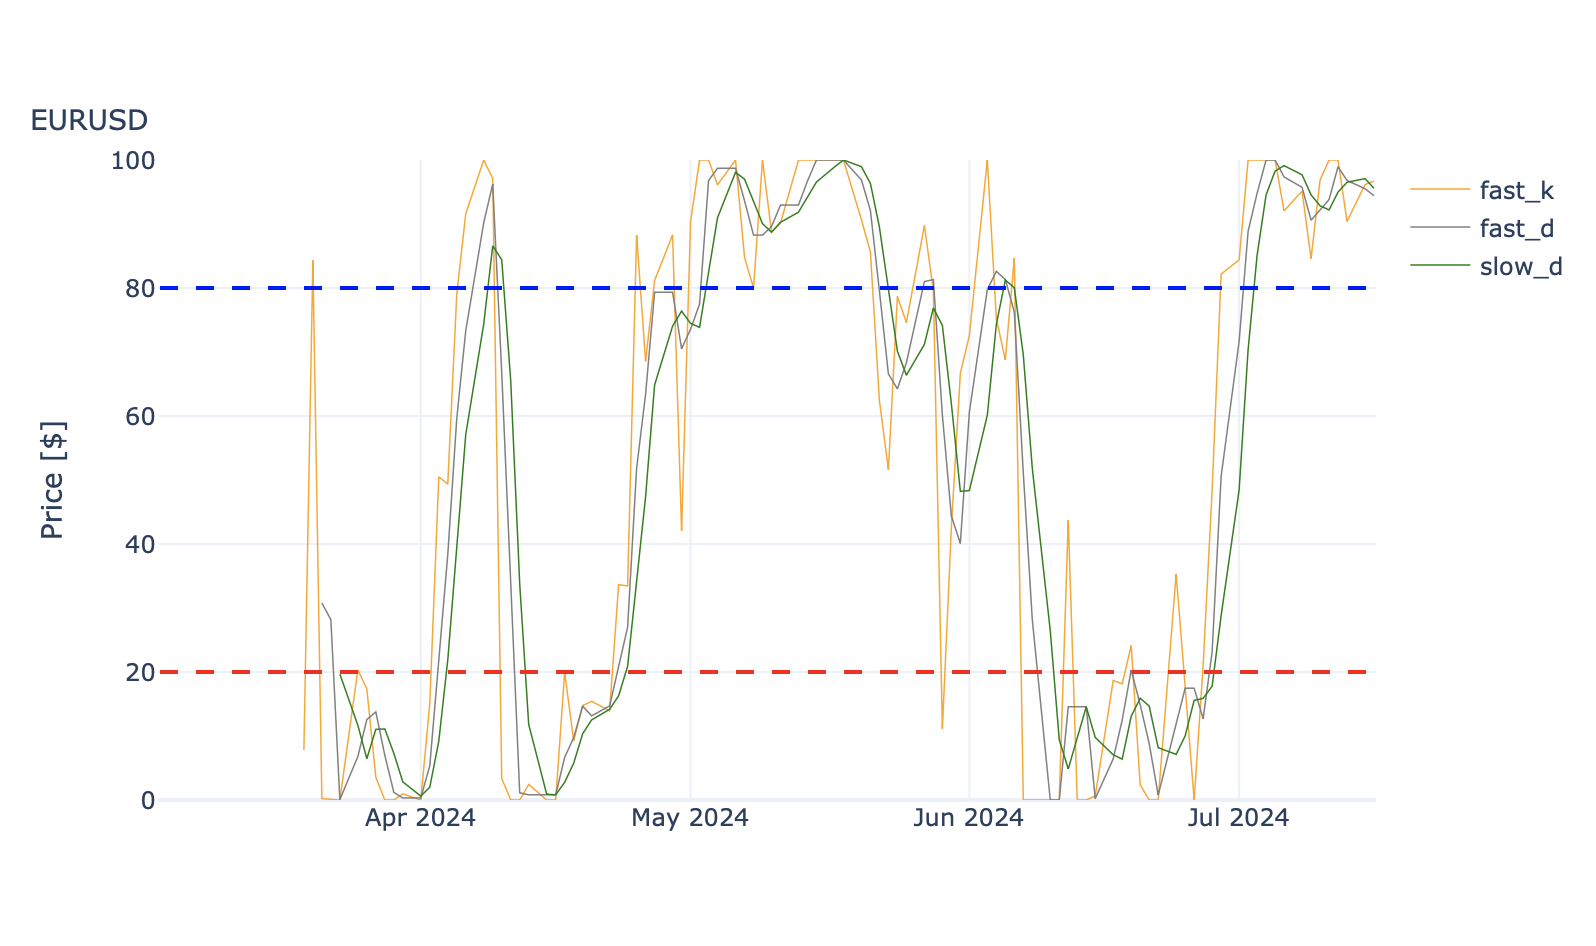

In [98]:
from IPython.display import Image, display
#static image just for review purposes
display(Image(filename='Visualization.png'))

In [91]:
from plotly.subplots import make_subplots

def chart_stochastic_oscillator_and_price(ticker, df):
    # Calculate moving averages
    df['ma50'] = df['close'].rolling(50).mean()
    df['ma200'] = df['close'].rolling(200).mean()

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        row_heights=[0.7, 0.3], vertical_spacing=0.02,
                        subplot_titles=(ticker, ''))

    fig.add_trace(go.Scatter(x=df['time'], y=df['close'], mode='lines', name='Close', line=dict(color='black', width=1), hoverinfo='none'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['ma50'], mode='lines', name='MA50', line=dict(color='blue', width=1), hoverinfo='none'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['ma200'], mode='lines', name='MA200', line=dict(color='red', width=1), hoverinfo='none'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df['time'], y=df['fast_k'], mode='lines', name='fast_k', line=dict(color='orange', width=1), hoverinfo='none'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['fast_d'], mode='lines', name='fast_d', line=dict(color='grey', width=1), hoverinfo='none'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['slow_d'], mode='lines', name='slow_d', line=dict(color='green', width=1), hoverinfo='none'), row=2, col=1)

    fig.add_shape(type='line', x0=df['time'].min(), x1=df['time'].max(), y0=80, y1=80, line=dict(color='blue', dash='dash'), row=2, col=1)
    fig.add_shape(type='line', x0=df['time'].min(), x1=df['time'].max(), y0=20, y1=20, line=dict(color='red', dash='dash'), row=2, col=1)

    fig.update_layout(
        height=800,
        width=1000,
        template='plotly_white',
        showlegend=True
    )

    fig.update_yaxes(title_text='Price [$]', row=1, col=1)
    fig.update_yaxes(title_text='S.O.', range=[0, 100], row=2, col=1)
    fig.update_xaxes(title_text='Time', row=2, col=1)
    fig.show()


In [92]:
chart_stochastic_oscillator_and_price(symbol.symbol, df)



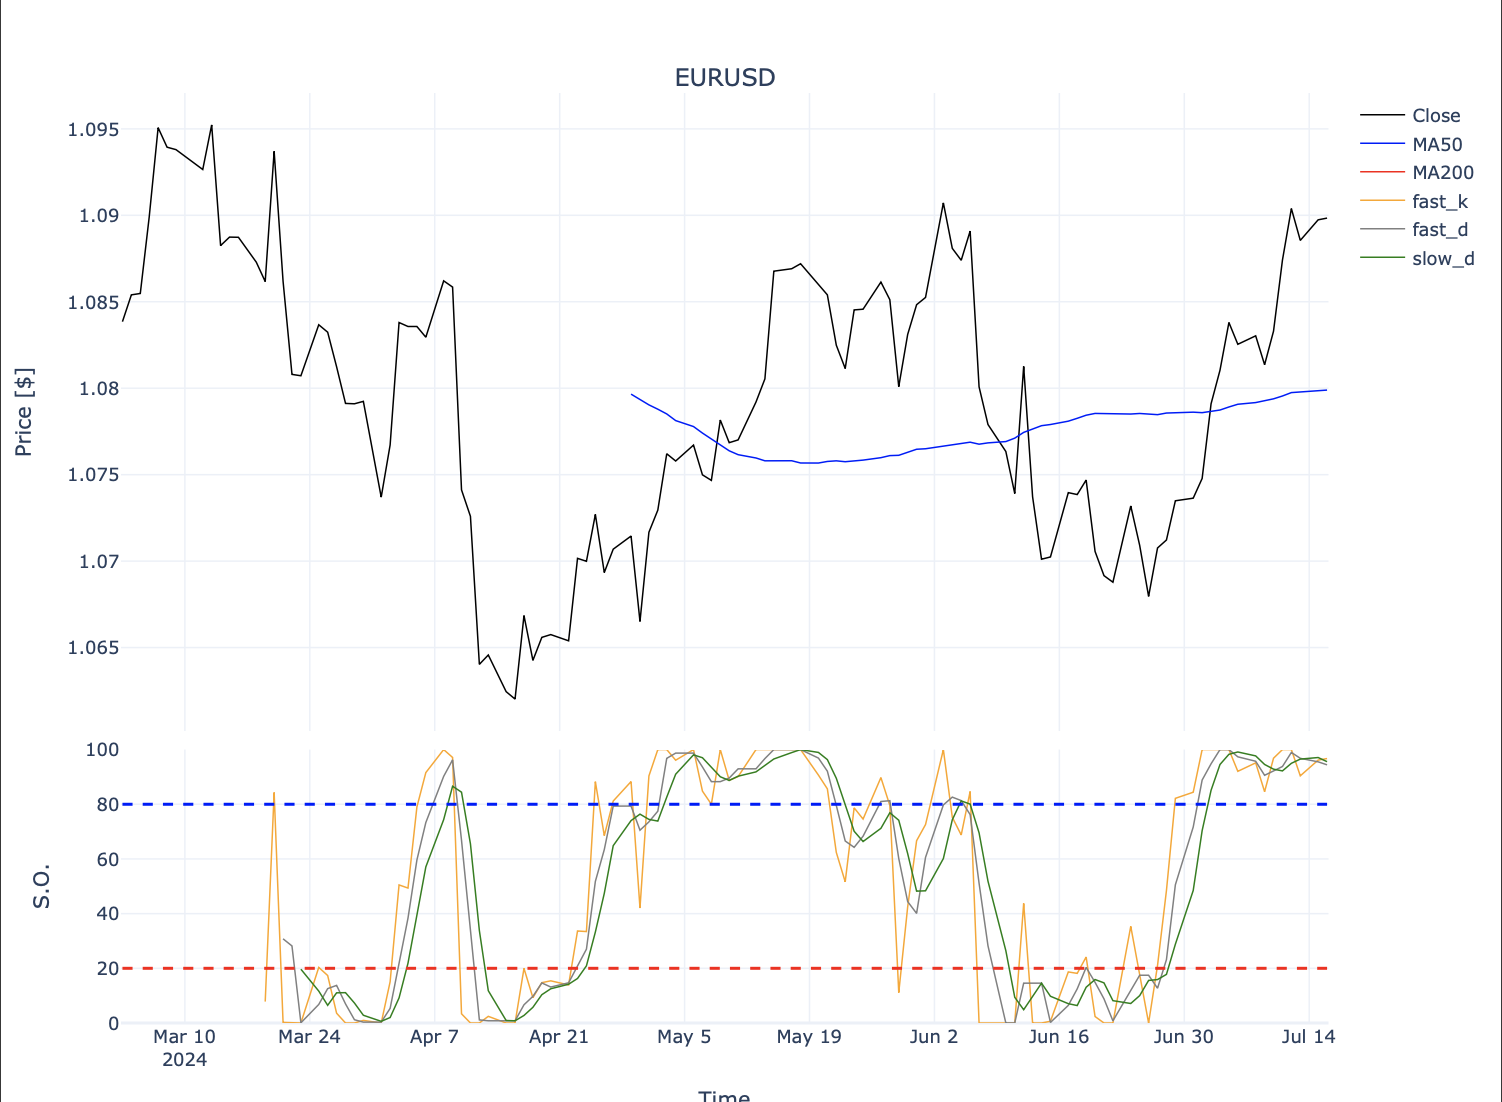

In [97]:
#static image just for review purposes

display(Image(filename='/img/chart_stochastic_oscillator_and_price..png'))